In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import xarray as xr
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import quantile_transform

# Select individuals based on genetic information and extract meta information

In [2]:
path_pheno = "/u/project/sriram/ukbiobank/33127/ukb21970.csv"
path_admixture = "00_data/supervised_with_sire.txt" # output from SCOPE program

In [3]:
col_age = "21003-0.0"
col_sex = "31-0.0"
col_pcs = [f"22009-0.{i}" for i in range(1, 41)]
col_report_ethnic = "21000-0.0"
col_id = "eid"

cols = [col_id, col_age, col_sex, col_report_ethnic] + col_pcs
col_names = ["ID", "AGE", "SEX", "SIRE_ID"] + [f"PC{i + 1}" for i in range(len(col_pcs))]

In [4]:
pheno = pd.read_csv(path_pheno, usecols=cols)[cols]
pheno.columns = col_names
pheno.ID = pheno.ID.astype(str)
pheno = pheno.set_index("ID")

admixture = pd.read_csv(path_admixture, index_col=0, sep='\t')
admixture.index = admixture.index.astype(str)

pheno = pd.merge(pheno, admixture, left_index=True, right_index=True)

4327 admixed individuals were selected


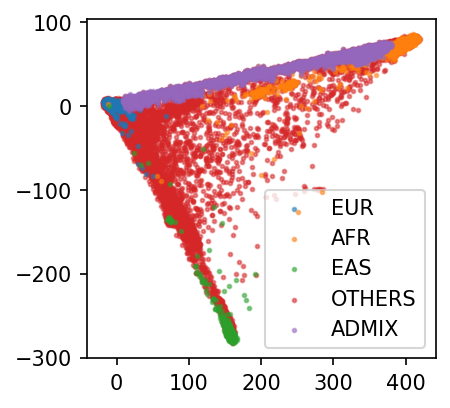

In [5]:
id_eur = pheno[pheno.SIRE == "British"].index
id_afr = pheno[pheno.SIRE == "African"].index
id_eas = pheno[pheno.SIRE == "Chinese"].index
id_other = list(set(pheno.index) - set(id_eur) - set(id_afr) - set(id_eas))

id_admix = pheno.index[(pheno.AFR > 0.05) & (pheno.EUR > 0.05) & (pheno.EAS < 0.05) & (pheno.SAS < 0.05)]
print(f"{len(id_admix)} admixed individuals were selected")

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for id_pop, label in zip([id_eur, id_afr, id_eas, id_other, id_admix], ["EUR", "AFR", "EAS", "OTHERS", "ADMIX"]):
    if label == "EUR":
        id_pop = np.random.choice(id_pop, 5000, replace=False)
    zorder = 0 if label == "OTHERS" else 10
    if label == "ADMIX":
        zorder = 20
    ax.scatter(pheno.loc[id_pop, "PC1"], pheno.loc[id_pop, "PC2"], label=label, alpha=0.5, s=3, zorder=zorder)

plt.legend()

In [6]:
np.savetxt("00_data/admix_indiv.txt", np.vstack([id_admix.values, id_admix.values]).T, delimiter='\t', fmt="%s")
pheno.loc[id_admix, :].to_csv("00_data/meta_info.csv")

# Extract trait phenotype

In [7]:
# extract phenotype from another file (because in another UKB application)
col_dict = {
    "21003-0.0": "AGE",
    "31-0.0": "SEX",
    "21000-0.0": "SIRE",
    "eid": "ID",
    "30897-0.0": "dilution_factor",
    "30690-0.0": "cholesterol",
    "30780-0.0": "ldl_direct",
    "30760-0.0": "hdl_cholesterol"
}

path_pheno = "/u/project/sriram/ukbiobank/33127/ukb39967.enc_ukb.converted2.csv"

trait_pheno = pd.read_csv(path_pheno, usecols=col_dict.keys()).rename(columns=col_dict)
trait_pheno.ID = trait_pheno.ID.astype(str)
trait_pheno = trait_pheno.set_index("ID")

In [8]:
from IPython.display import display, HTML, Markdown
# make sure two phenotype file matches
meta_info = pd.read_csv("00_data/meta_info.csv", index_col=0)
meta_info.index = meta_info.index.astype(str)
merged = meta_info.join(trait_pheno, rsuffix='_trait')

for col in ["SEX", "AGE"]:
    display(Markdown(f"## {col}"))
    display(merged[merged[f"{col}_trait"] != merged[col]])
display(Markdown(f"## SIRE"))
display(merged[merged["SIRE_trait"] != merged["SIRE_ID"]])
# these mismatch individuals correspond to missing phenotype
# will cope with these in association
merged.to_csv("00_data/trait_pheno.csv")

## SEX

,AGE,SEX,SIRE_ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,EUR,SAS,SIRE,SEX_trait,SIRE_trait,AGE_trait,cholesterol,hdl_cholesterol,ldl_direct,dilution_factor
5841951,55,0,4001.0,344.109,64.2523,-8.57264,5.05607,1.01965,0.665122,-3.47168,...,0.106441,0.012949,Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## AGE

,AGE,SEX,SIRE_ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,EUR,SAS,SIRE,SEX_trait,SIRE_trait,AGE_trait,cholesterol,hdl_cholesterol,ldl_direct,dilution_factor
5841951,55,0,4001.0,344.109,64.2523,-8.57264,5.05607,1.01965,0.665122,-3.47168,...,0.106441,0.012949,Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SIRE

,AGE,SEX,SIRE_ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,EUR,SAS,SIRE,SEX_trait,SIRE_trait,AGE_trait,cholesterol,hdl_cholesterol,ldl_direct,dilution_factor
1168072,48,1,NaN,332.5570,64.79240,-5.603890,1.104930,-1.771140,-1.708100,-4.806400,...,0.149456,0.016820,Do not know,1.0,NaN,48.0,5.431,1.098,3.420,0.993463
1529443,65,1,NaN,145.5840,32.05490,1.633380,-15.596400,3.017780,0.144049,6.721240,...,0.596752,0.017971,Do not know,1.0,NaN,65.0,5.186,1.045,3.370,1.002980
1595335,47,0,NaN,324.2560,61.50340,-6.104580,4.247780,-2.547880,3.330120,-5.312460,...,0.150376,0.025810,Do not know,0.0,NaN,47.0,2.808,1.431,1.325,1.004270
1804222,48,0,NaN,234.4210,43.83270,-6.893090,0.334550,-1.262950,6.192830,0.671335,...,0.391297,0.021872,Do not know,0.0,NaN,48.0,5.481,1.370,3.520,1.001170
2143156,59,1,NaN,48.3585,9.29026,1.305160,-1.466670,-3.472300,-2.973370,2.413120,...,0.852833,0.020443,Do not know,1.0,NaN,59.0,6.587,1.424,4.233,1.000740
2953252,68,0,NaN,366.8170,73.20770,-4.702320,6.865320,-2.381090,1.147820,-1.191260,...,0.050319,0.015607,Do not know,0.0,NaN,68.0,4.763,1.531,3.021,1.005700
3169934,52,1,NaN,12.2970,2.64207,6.490200,-30.050100,6.336000,-2.255890,17.567900,...,0.917436,0.030899,Do not know,1.0,NaN,52.0,5.522,1.066,3.598,1.008170
3361126,63,1,NaN,342.3860,67.32070,-5.742190,6.297100,0.612043,-0.676849,-1.532790,...,0.128158,0.012939,Do not know,1.0,NaN,63.0,3.386,NaN,1.803,0.987492
3749755,62,0,NaN,216.1980,34.86370,11.478800,-31.403000,2.753530,-0.307258,10.939800,...,0.417065,0.039453,Do not know,0.0,NaN,62.0,4.612,1.084,2.877,0.999714
4045563,66,1,NaN,295.4590,56.53600,-0.801322,0.178833,0.362361,-3.089330,0.633111,...,0.236407,0.023383,Do not know,1.0,NaN,66.0,6.948,1.006,4.305,0.997054
